In [15]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import re


In [16]:
# Function to create transects by selecting points around target theta2 values
def create_transects_around_target_theta2(point_cloud, target_theta2_values, theta_range=1.5):
    return [point_cloud[(point_cloud['theta'] >= target_theta2 - theta_range) & 
                        (point_cloud['theta'] <= target_theta2 + theta_range)] 
            for target_theta2 in target_theta2_values]

# Function to check if all values in the point_cloud_df have been assigned to a transect
def check_unassigned_points(point_cloud_df, transects):
    assigned_points = pd.concat(transects)
    return point_cloud_df[~point_cloud_df.index.isin(assigned_points.index)].shape[0]


In [17]:
# Define the transformation matrix gathered from CloudCompare georeferencing #lidar 2
transformation_matrix = np.array([
    [-0.000016770196,  0.000814016035, -0.000582627312,  492.124877929688],
    [ 0.000013774332, -0.000582466251, -0.000814187515,  127.395973205566],
    [-0.001000943012, -0.000021653870, -0.000001442754,    4.594210147858],
    [ 0.000000000000,  0.000000000000,  0.000000000000,    1.000000000000]
])

# #lidar1 
# transformation_matrix = np.array([
#     [-0.000024980998,  0.000812676153, -0.000583815563,  492.143829345703],
#     [ 0.000007067249, -0.000583839603, -0.000813012011,  127.397300720215],
#     [-0.001000616350, -0.000024412553,  0.000008833092,    4.558271408081],
#     [ 0.000000000000,  0.000000000000,  0.000000000000,    1.000000000000]
# ])

transformation_matrix[0,3]+=  72000.00 
transformation_matrix[1,3]+=  452000.00
transformation_matrix[3,3]=1


#### select pcd file ####
it is nice to see the amount of erosion between the start and the end of the storm. run entire script

In [18]:
# Load point cloud
# map_naam = r"U:\Data\2024-12-22, Storm 2\Lidars\20241223_LiDAR2\10s interval data\Lidar2__Pcl_0023_12_2024__12_06_30.062.PCD"  #Lidar2 23th dec 2024
map_naam = r'U:\Data\2024-12-22, Storm 2\Lidars\20241223_LiDAR2\10s interval data\Lidar2__Pcl_0021_12_2024__16_20_30.064.PCD' #Lidar2 21th dec 2024
# map_naam = r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0022_12_2024__21_32_32.780.PCD" #Lidar1 22th dec 2024 
pcd = o3d.io.read_point_cloud(map_naam)
pcd

PointCloud with 6357 points.

In [19]:
# Extract points as a NumPy array
xyz = np.asarray(pcd.points)

# Convert to spherical coordinates with the z-axis as the reference axis
x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
rho = np.sqrt(x**2 + y**2 + z**2)
phi = np.arctan2(y, x)
theta_degrees = np.degrees(np.arccos(z / rho))

# Create a DataFrame to store the point cloud data along with theta values
point_cloud_df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'theta': theta_degrees})

# Define the target theta2 values for each transect
target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]

# Generate transects with theta2 values around the specified target values with increased range
transects = create_transects_around_target_theta2(point_cloud_df, target_theta2_values, theta_range=1)

# Rename the transects starting from 1 going to 16
transect_names = [f'Transect {i}' for i in range(1, 17)]
transect_dict = dict(zip(transect_names, transects))

# Count the number of points in each transect
transect_point_counts = {name: len(transect) for name, transect in transect_dict.items()}

# Check for unassigned points
unassigned_points_count = check_unassigned_points(point_cloud_df, transects)
if unassigned_points_count > 0:
    print(f"Unassigned points count: {unassigned_points_count}")

# Remove the 'theta' column from each transect DataFrame
for name in transect_dict:
    transect_dict[name] = transect_dict[name].drop(columns=['theta'])

### we will now select a specifif transect for further processing ###
# Select Transect 3 for transformation
A = 3
transect_A = transect_dict[f'Transect {A}']


In [20]:
# Convert transect DataFrame to NumPy array
transect_xyz = transect_A[['x', 'y', 'z']].values

# Apply the transformation matrix
transect_xyz_homogeneous = np.hstack((transect_xyz, np.ones((transect_xyz.shape[0], 1))))
transect_xyz_transformed = transect_xyz_homogeneous.dot(transformation_matrix.T)[:, :3]

# Create a DataFrame for the transformed transect
transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])
# print(transect_transformed_df)
# print(transect_transformed_df.shape)

#########
# place to add external data like GPS, or lidar drone, as data is now in RD coordinates
#########


# Compute the translation back offsets for X and Y only
translation_back = np.eye(4)
translation_back[0, 3] = -transformation_matrix[0, 3]
translation_back[1, 3] = -transformation_matrix[1, 3]

# Apply the translation back to the origin for X and Y
transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
transect_xyz_transformed = transect_xyz_homogeneous.dot(translation_back.T)[:, :3]
transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

### rotatate back to cross-shore and long-shore orientation ###
By selecting 2 points, in this case point3 and point4 of hinter side of the dike element, we can now rotate the point cloud back so that that the orientation in the x and y are respectivily cross-shore and long-shore. Between the two point we divine and set as zero point for the new cross-shore axis. This so that all the dike elements have the same distance to a longshore line and we can compare the different elements to see which have the most dune face retreat.

In [21]:
# Coordinates of the two points in the RD-coordinate system
    # Coordinates of the two points in the RD-coordinate system
point2 = np.array([72465.165, 452065.649, 4.530, 1])  # S3 plaatTopHoek3
point1 = np.array([72479.379, 452085.167, 4.598, 1])  # S3 plaatTopHoek4

# Step 1: Compute the direction vector
direction = point1 - point2

# Step 2: Project the direction vector onto the XY-plane
direction_xy = direction[:2]  # Only consider the X and Y components

# Step 3: Compute the angle to the Y-axis
angle = np.arctan2(direction_xy[0], direction_xy[1])  # atan2(X, Y)

# Step 4: Construct the rotation matrix for rotation around the Z-axis
rotation_matrix = np.array([
    [np.cos(angle), -np.sin(angle), 0, 0],
    [np.sin(angle),  np.cos(angle), 0, 0],
    [0,              0,             1, 0],
    [0,              0,             0, 1]
])

# Print the rotation matrix
print("Rotation Matrix (around Z-axis):")
print(rotation_matrix)

# Apply the rotation and translation matrix to the two points
new_point1 = np.dot(translation_back, point1)
new_point2 = np.dot(translation_back, point2)
new_point1 = np.dot(rotation_matrix, new_point1)
new_point2 = np.dot(rotation_matrix, new_point2)

print(f'point1 = {point1} and in new system this is {new_point1}')
print(f'point2 = {point2} and in new system this is {new_point2}')

# this is the new baseline axis in the new system, we apply this later on
baseline_axis = np.mean([new_point1[0], new_point2[0]])
print(f'baseline_axis = {baseline_axis}')


# Apply the rotation matrix to the point cloud
transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
transect_xyz_transformed = transect_xyz_homogeneous.dot(rotation_matrix.T)[:, :3]
transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

# rename transect_transformed_df to df for easier plotting
df = transect_transformed_df.rename(columns={'x': 'x', 'y': 'y', 'z': 'z'})



Rotation Matrix (around Z-axis):
[[ 0.80835982 -0.58868872  0.          0.        ]
 [ 0.58868872  0.80835982  0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
point1 = [7.24793790e+04 4.52085167e+05 4.59800000e+00 1.00000000e+00] and in new system this is [ 14.55646462 -41.63955956   4.598        1.        ]
point2 = [7.24651650e+04 4.52065649e+05 4.53000000e+00 1.00000000e+00] and in new system this is [ 14.55646462 -65.7847479    4.53         1.        ]
baseline_axis = 14.556464615405716


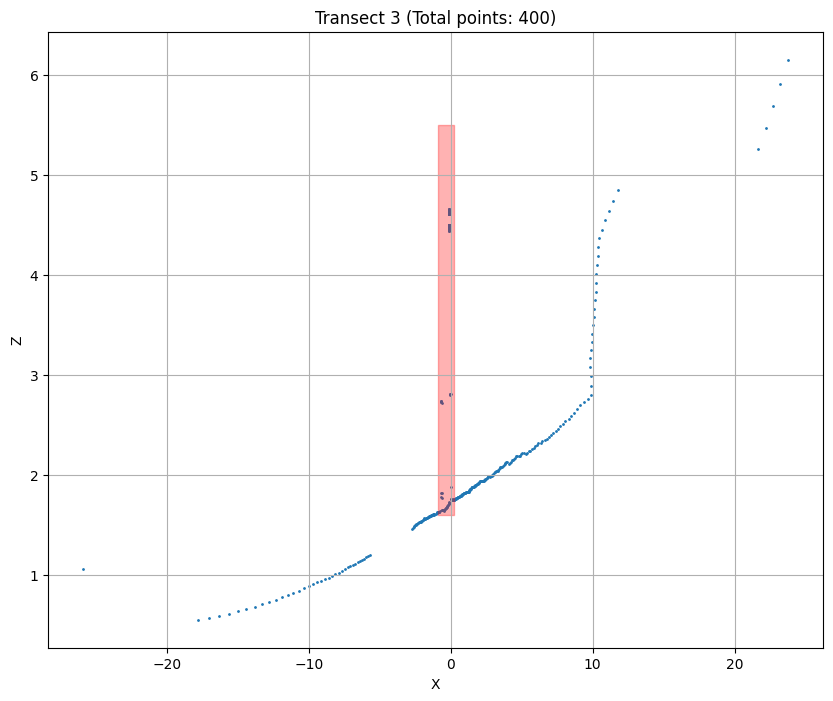

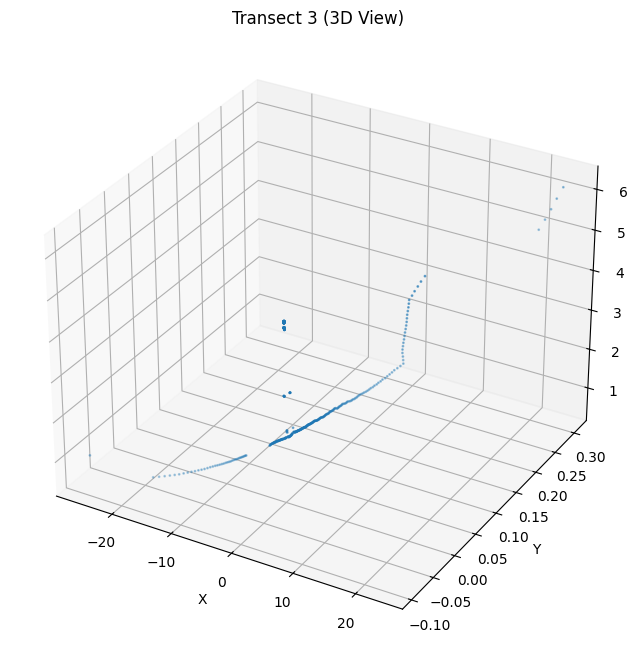

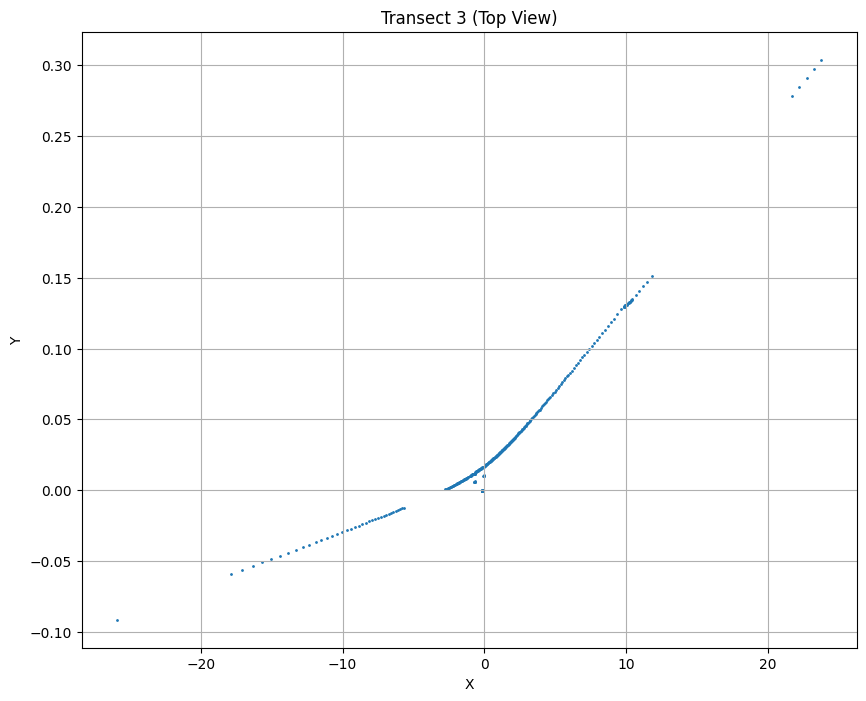

In [22]:
# Plot the transformed transect
plt.figure(figsize=(10, 8))
plt.scatter(df['x'], df['z'], s=1)
plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'Transect {A} (Total points: {transect_point_counts[f"Transect {A}"]})')
plt.grid(True)

## Add transparent red plane that indicated the to be removed area ##
z1 ,z2,x1,x2= 1.6 , 5.5, -0.9, 0.2
plt.fill_betweenx([z1, z2], x1, x2, color='red', alpha=0.3)

plt.show()

# 3D plot of the transformed transect
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Transect {A} (3D View)')
plt.show()

# Top view plot (x vs y)
plt.figure(figsize=(10, 8))
plt.scatter(df['x'], df['y'], s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Transect {A} (Top View)')
plt.grid(True)
plt.show()

In [23]:
# remove points between z= [z1,z2], x=[x1,x2]
df = df[(df['z'] < z1) | (df['z'] > z2) | (df['x'] < x1) | (df['x'] > x2)]
# remove points above z=6
df = df[(df['z'] < 6)]


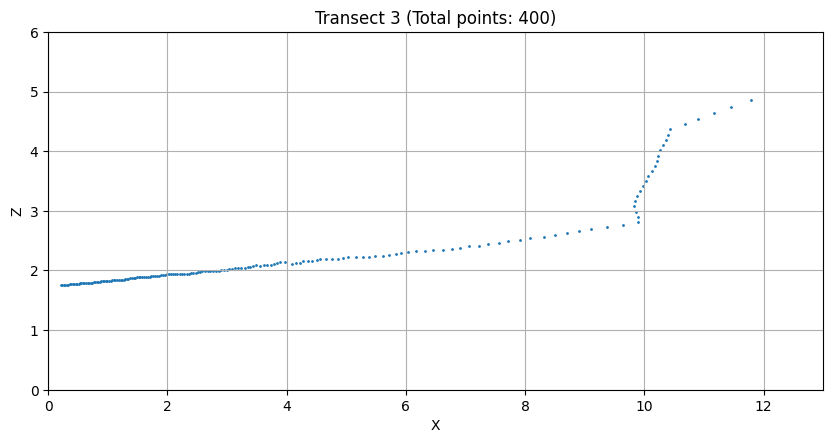

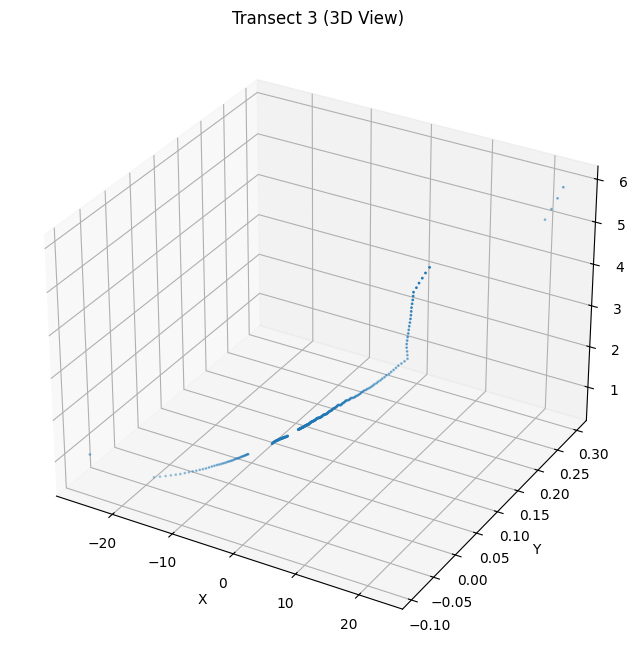

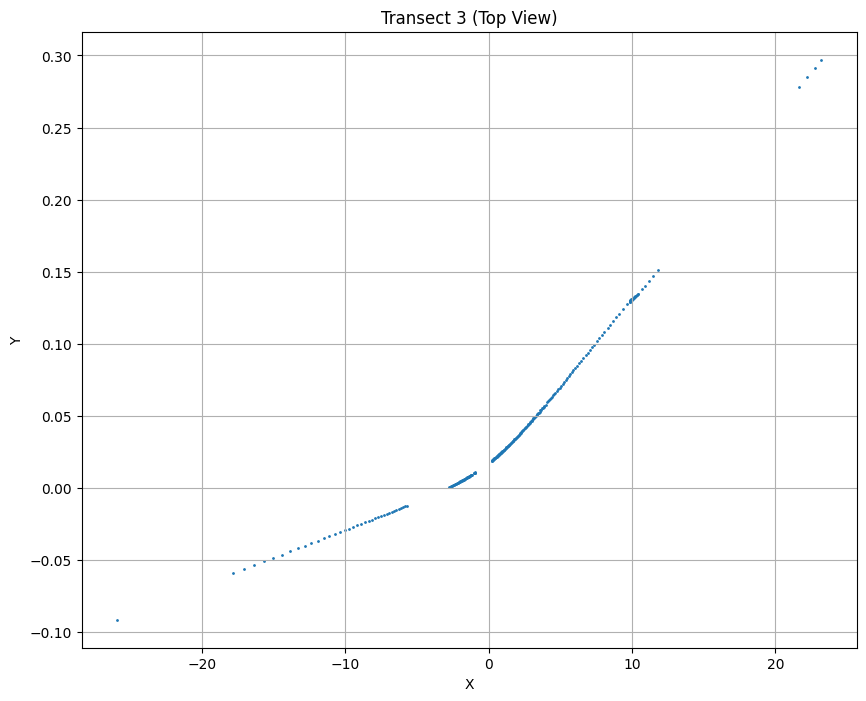

In [24]:
# Plot the transformed transect
plt.figure(figsize=(10, 8))
plt.scatter(df['x'], df['z'], s=1)
plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'Transect {A} (Total points: {transect_point_counts[f"Transect {A}"]})')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.ylim(0, 6)
plt.xlim(0,13)
plt.show()

# 3D plot of the transformed transect
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Transect {A} (3D View)')
plt.show()

# Top view plot (x vs y)
plt.figure(figsize=(10, 8))
plt.scatter(df['x'], df['y'], s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Transect {A} (Top View)')
plt.grid(True)
plt.show()

### base line cross-shore axis ###
now that we have rotated the PC back to cross-shore and long-shore orientation, want to translate the PC so that we can compare all the different dike elements with eachother. to do this we use the new baseline axis - 100 meters, so that the original scarp is at 100[m] on the x-axis
 

In [25]:
baseline_axis = baseline_axis - 100
# apply baseline axis translation to the data
df['x'] = df['x'] - baseline_axis


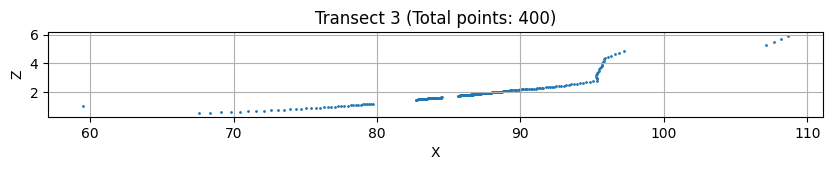

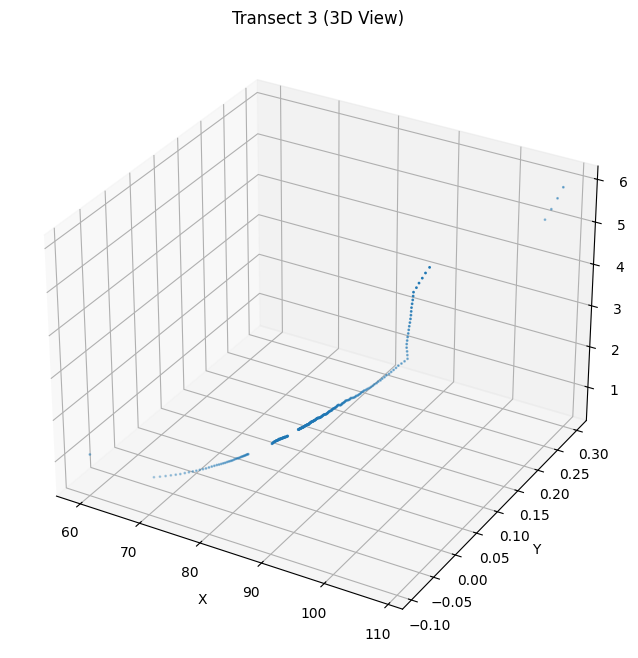

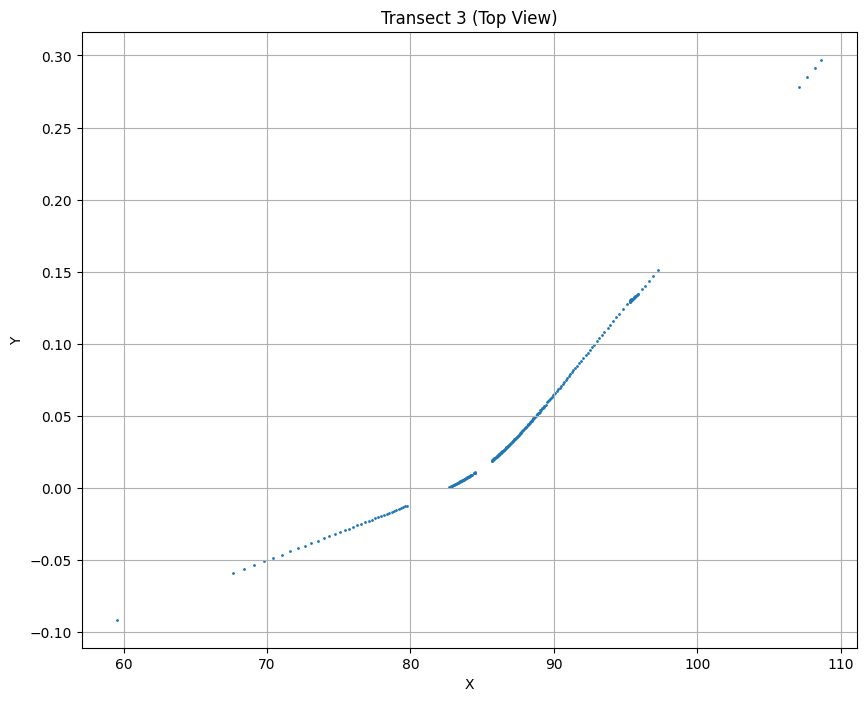

In [26]:
# Plot the transformed transect
plt.figure(figsize=(10, 8))
plt.scatter(df['x'], df['z'], s=1)
plt.xlabel('X')
plt.ylabel('Z')
plt.title(f'Transect {A} (Total points: {transect_point_counts[f"Transect {A}"]})')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# 3D plot of the transformed transect
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Transect {A} (3D View)')
plt.show()

# Top view plot (x vs y)
plt.figure(figsize=(10, 8))
plt.scatter(df['x'], df['y'], s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Transect {A} (Top View)')
plt.grid(True)
plt.show()

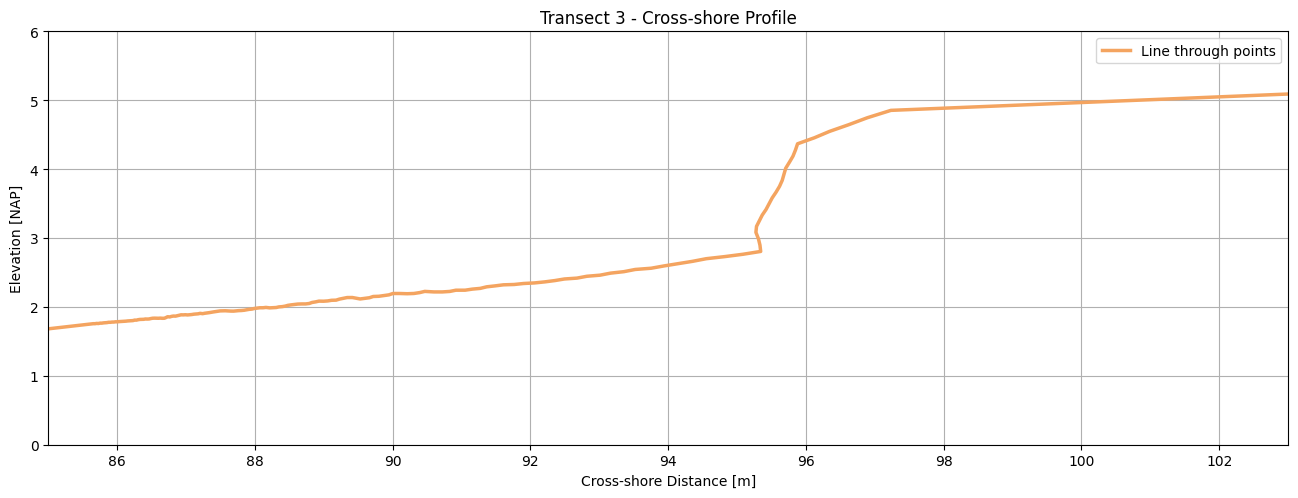

In [27]:
# Plot the transformed transect
plt.figure(figsize=(16, 8))
# Add a line through the points
plt.plot(df['x'], df['z'], color='sandybrown', linewidth=2.5, label='Line through points')
# plt.scatter(df['x'], df['z'], s=10, color='sandybrown', label='Points')
plt.xlabel('Cross-shore Distance [m]')
plt.ylabel('Elevation [NAP]')
plt.title(f'Transect {A} - Cross-shore Profile')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(85, 103)
plt.ylim(0, 6)
plt.legend()

plt.show()